## 0. 라이브러리 & 데이터로딩

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)

- [torchvision 내장 datasets 목록](https://pytorch.org/vision/stable/datasets.html)

In [2]:
train_set = FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_set = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
classes = {0 : "T-shirt/top",
           1 : "Trouser",
           2 : "Pullover",
           3 : "Dress",
           4 : "Coat",
           5 : "Sandal",
           6 : "Shirt",
           7 : "Sneaker",
           8 : "Bag",
           9 : "Ankle boot"}

torch.Size([1, 28, 28])


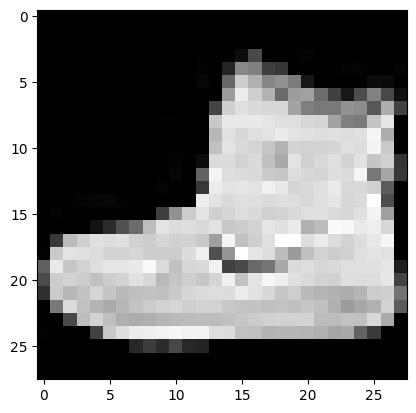

In [4]:
print(train_set[0][0].shape)
plt.imshow(train_set[0][0].squeeze(), cmap='gray');

In [5]:
print(train_set[0][1])
print(classes.get(train_set[0][1]))

9
Ankle boot


- 미니배치를 위한 Data Loader 생성

In [6]:
bsize = 64
train_dataloader = DataLoader(train_set, batch_size=bsize)
test_dataloader = DataLoader(test_set, batch_size=bsize)

for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 1. 모델 정의

- device 정의

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


- 모델 정의

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


- [손실함수](https://pytorch.org/docs/stable/nn.html#loss-functions)와 [옵티마이저](https://pytorch.org/docs/stable/optim.html) 정의

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

## 2. 모델 학습

- 학습 함수 정의

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        # 손실 점수 계산
        pred = model(x)
        loss = loss_fn(pred, y)
        # 기울기 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

- 성능 검증 함수 정의

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

- 학습

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297364  [   64/60000]
loss: 0.614701  [ 6464/60000]
loss: 0.462681  [12864/60000]
loss: 0.492310  [19264/60000]
loss: 0.469078  [25664/60000]
loss: 0.428475  [32064/60000]
loss: 0.426354  [38464/60000]
loss: 0.543785  [44864/60000]
loss: 0.448150  [51264/60000]
loss: 0.470992  [57664/60000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.448230 

Epoch 2
-------------------------------
loss: 0.290488  [   64/60000]
loss: 0.321670  [ 6464/60000]
loss: 0.257415  [12864/60000]
loss: 0.330628  [19264/60000]
loss: 0.348151  [25664/60000]
loss: 0.360861  [32064/60000]
loss: 0.330026  [38464/60000]
loss: 0.425225  [44864/60000]
loss: 0.371534  [51264/60000]
loss: 0.438212  [57664/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.397618 

Epoch 3
-------------------------------
loss: 0.243736  [   64/60000]
loss: 0.337049  [ 6464/60000]
loss: 0.208807  [12864/60000]
loss: 0.285832  [19264/60000]
loss: 0.343440  [25664/60000]
loss: 0.336970  [32064/600

## 3. 추론

In [13]:
r = np.random.randint(0,len(test_set))
print(r)
x, y = test_set[r][0], test_set[r][1]

8915


2 Pullover


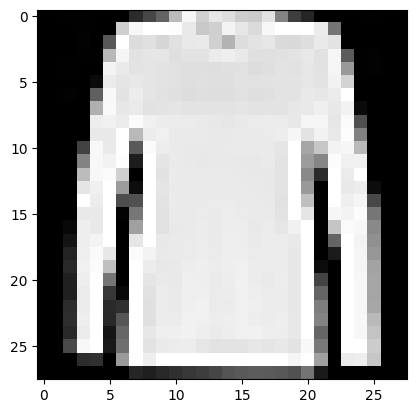

In [14]:
print(y, classes.get(y))
plt.imshow(x.squeeze(), cmap='gray');

In [15]:
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0).item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"
